# Installing the requirements for virtual environment

In [ ]:
# ! pip install -r requirements3.txt

# Importing all python Libraries

In [85]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
# Load original scaler
from sklearn.preprocessing import MinMaxScaler
import joblib
import random
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

## Setting Random Seeds for Reproducibility

In [86]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Setting Device for Computation (CPU or GPU)


In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download Apple Stock Data

###### library used : yfinance
###### Records      : 1,508 
###### Time period  : June 3, 2019 to May 30, 2025
###### approximately 6 years data

In [ ]:
#import yfinance as yf

#df = yf.download('AAPL', start='2019-06-03', end='2025-05-30')
#df.to_csv("apple.csv")

## Data Preprocessing and Preparation

#### Data Loading, Scaling, Sequence Generation, and Tensor Preparation


In [88]:
# Make sure directories exist
os.makedirs("model", exist_ok=True)

# Load and process data again
df = pd.read_csv("../dataset/apple.csv")
df = df[["Open", "High", "Low", "Close", "Volume"]].apply(pd.to_numeric, errors="coerce").dropna()

feature_cols = ["Open", "High", "Low", "Volume"]
target_col = ["Close"]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[feature_cols])
y_scaled = target_scaler.fit_transform(df[target_col])

# === Sequence Preparation ===
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 20
X, y = create_sequences(X_scaled, y_scaled, seq_length)

# === Split Data into Train (48%), Val (32%), Test (20%) ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.4, shuffle=False)

# === Convert to PyTorch tensors ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# === Save Tensors ===
torch.save(X_test_tensor, "model/X_test_tensor.pt")
torch.save(y_test_tensor, "model/y_test_tensor.pt")

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32,shuffle=True)

print("Test tensors saved successfully.")

Test tensors saved successfully.


## Visualize Train, Validation, and Test Splits


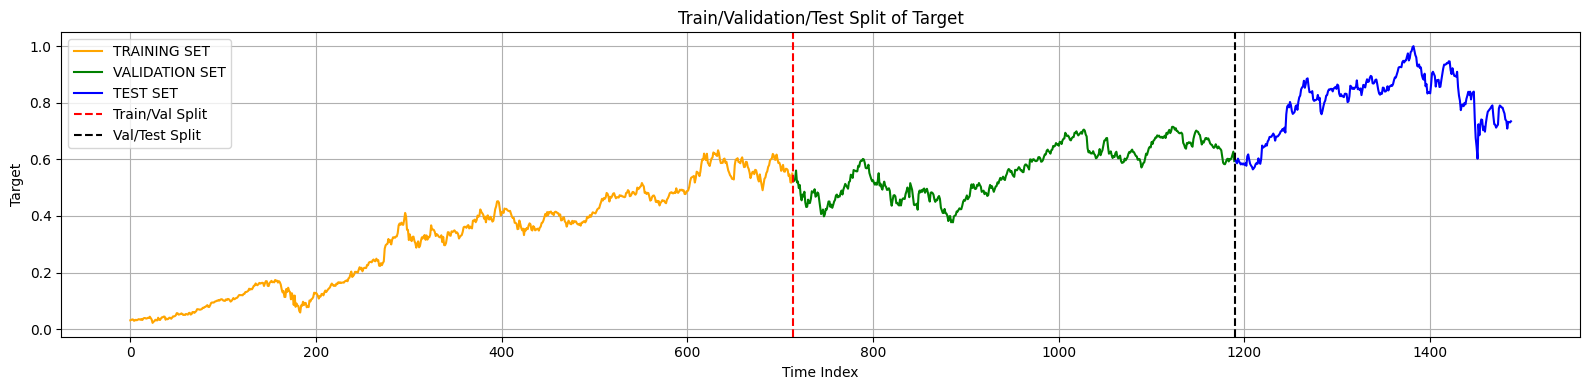

In [114]:
plt.figure(figsize=(16, 4))
total_len = len(X)

# Reconstruct full target sequence
full_y = np.concatenate([y_train, y_val, y_test])
full_range = np.arange(len(full_y))

train_end = len(y_train)
val_end = train_end + len(y_val)

# Plot sections
plt.plot(full_range[:train_end], y_train.flatten(), label='TRAINING SET', color='orange')
plt.plot(full_range[train_end:val_end], y_val.flatten(), label='VALIDATION SET', color='green')
plt.plot(full_range[val_end:], y_test.flatten(), label='TEST SET', color='blue')

# Mark boundaries
plt.axvline(train_end, color='red', linestyle='--', label='Train/Val Split')
plt.axvline(val_end, color='black', linestyle='--', label='Val/Test Split')

plt.title("Train/Validation/Test Split of Target")
plt.xlabel("Time Index")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()


## Load Test Tensors


In [89]:
# Load test tensors
X_test_tensor = torch.load("model/X_test_tensor.pt").to(device)
y_test_tensor = torch.load("model/y_test_tensor.pt").to(device)

## QLSTM Architecture and Setup :

###### Number of Qubits = 4 , Feature Map = ZZFeaturemap, Ansatz = RealAmplitude, QNN = EstimatorQNN

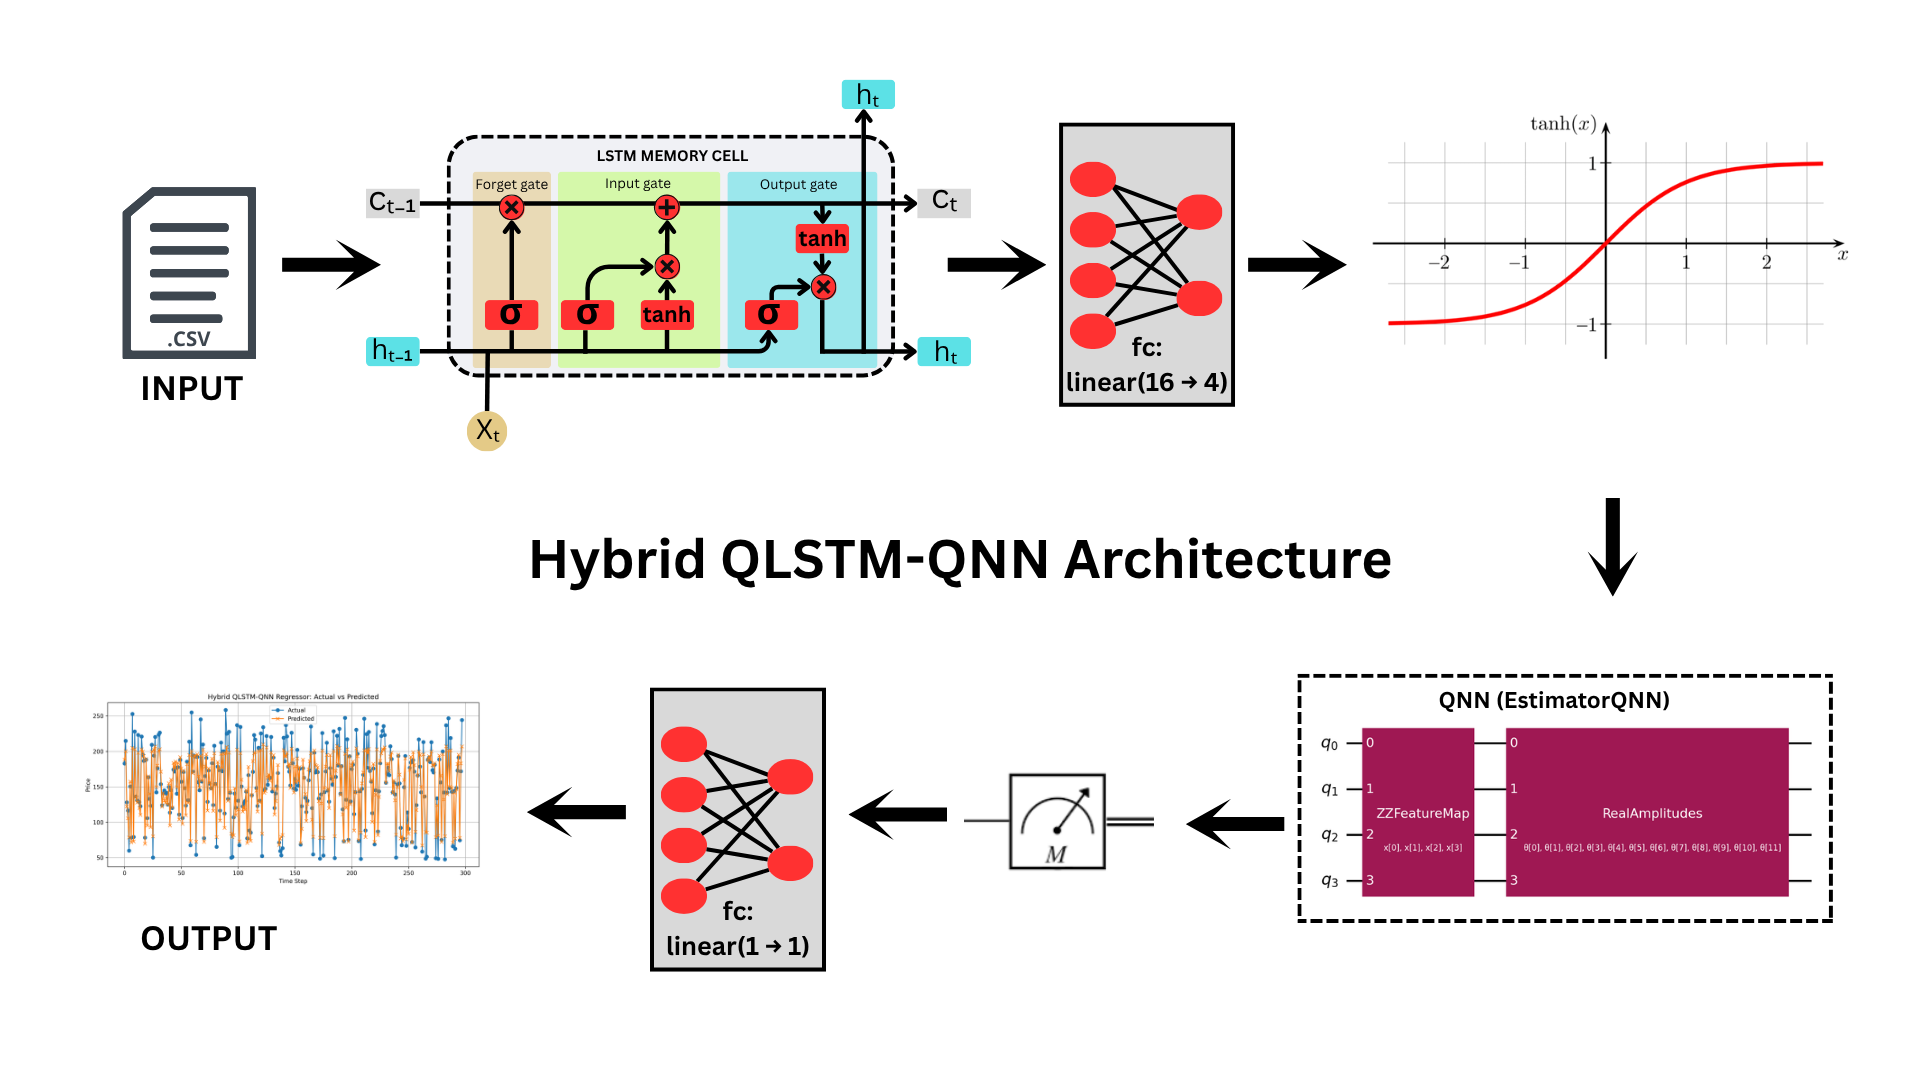


In [90]:
num_qubits = 4
feature_map = ZZFeatureMap(num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2, entanglement='full')
circuit = feature_map.compose(ansatz)

estimator = StatevectorEstimator()
qnn = EstimatorQNN(
    circuit=circuit,
    estimator=estimator,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)
quantum_layer = TorchConnector(qnn)

# === Define QLSTM Model ===
class QLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, quantum_layer):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_qubits)
        self.quantum = quantum_layer
        self.fc2 = nn.Linear(1, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = torch.tanh(self.fc1(out))
        out = self.quantum(out)
        out = self.fc2(out)
        return out

# === Initialize Model ===
model = QLSTM(input_size=4, hidden_size=16, quantum_layer=quantum_layer).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, eps=1e-8, momentum=0.9, weight_decay=1e-5)
loss_fn = nn.MSELoss()


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


## Visualize Quantum Circuit (Block-Level View)


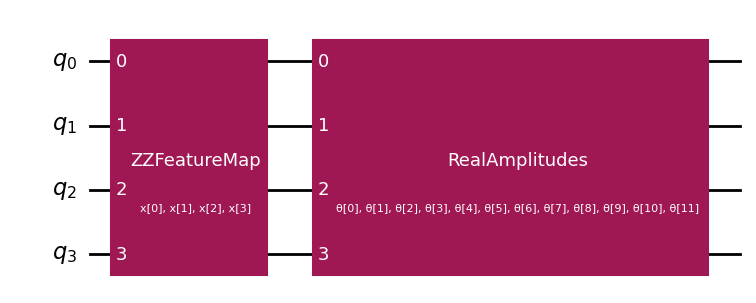

In [ ]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

qc_blocks = QuantumCircuit(num_qubits)
qc_blocks.append(feature_map.to_gate(label="ZZFeatureMap"), range(num_qubits))
qc_blocks.append(ansatz.to_gate(label="RealAmplitudes"), range(num_qubits))

circuit_drawer(qc_blocks, output='mpl')

## Visualize Detailed Quantum Circuit


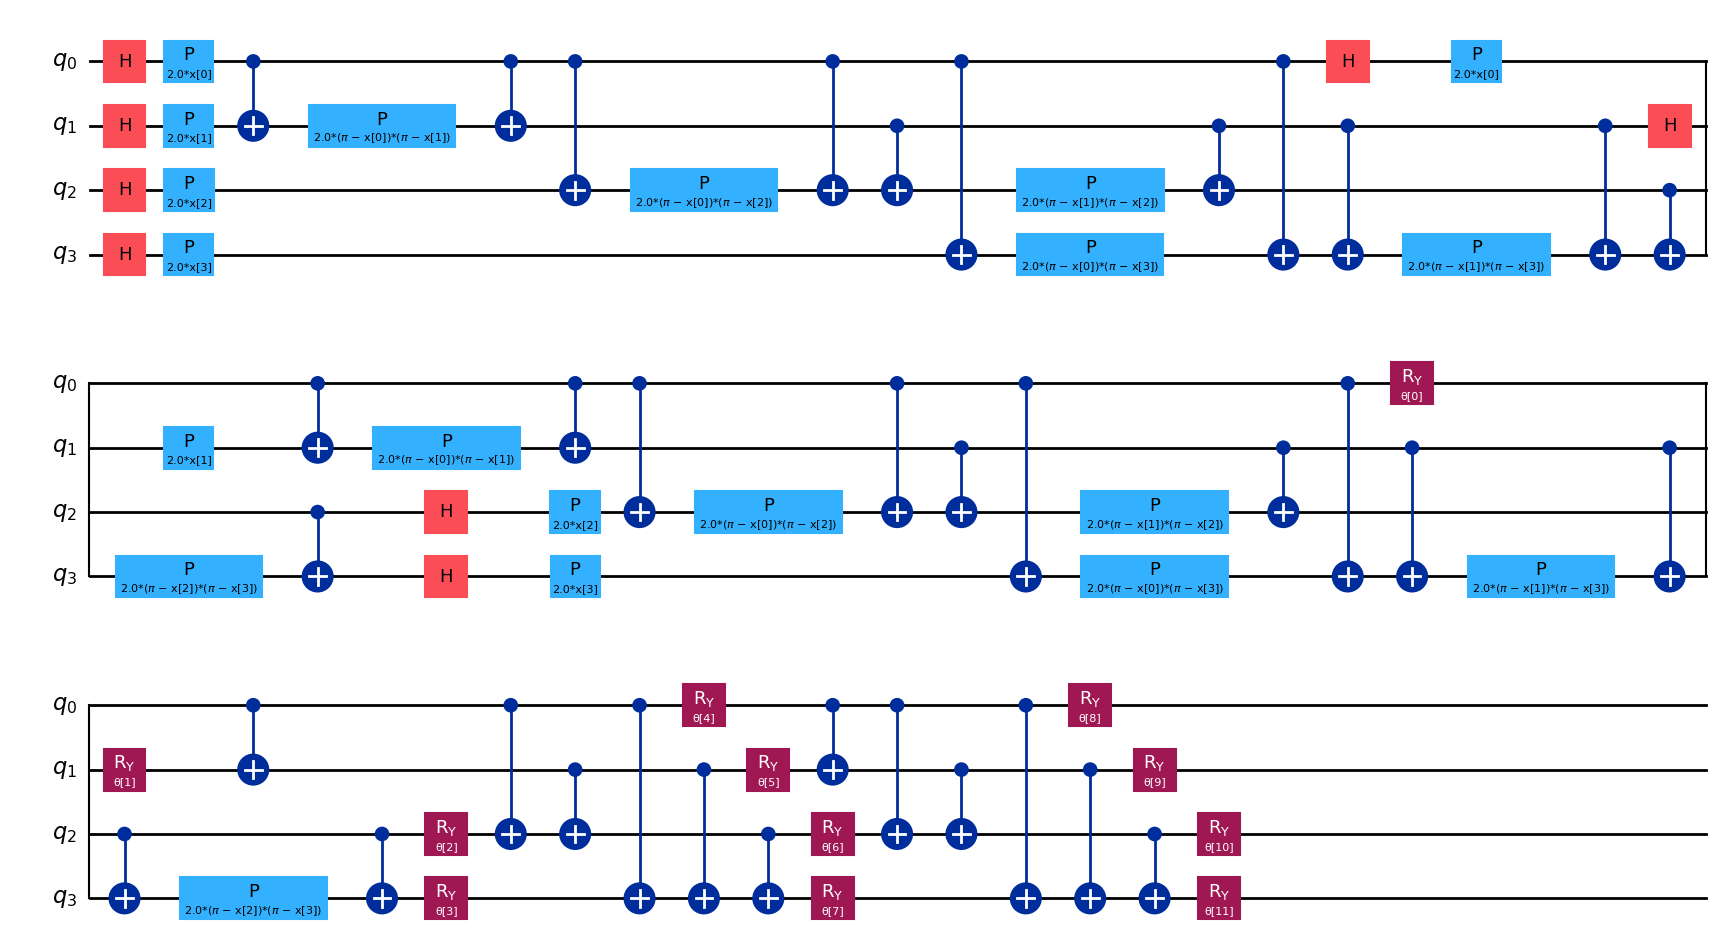

In [ ]:
detailed_qc = QuantumCircuit(num_qubits)
detailed_qc.compose(feature_map, inplace=True)
detailed_qc.compose(ansatz, inplace=True)

circuit_drawer(detailed_qc.decompose(), output='mpl')


## Train QLSTM Model with Early Stopping

In [91]:
epochs = 100
patience = 5
best_val_loss = float('inf')
counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            preds_val = model(xb_val)
            val_loss = loss_fn(preds_val, yb_val)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "model/best_qlstm_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/100 - Train Loss: 0.2593 - Val Loss: 0.0134
Epoch 2/100 - Train Loss: 0.0368 - Val Loss: 0.0360
Epoch 3/100 - Train Loss: 0.0092 - Val Loss: 0.0038
Epoch 4/100 - Train Loss: 0.0015 - Val Loss: 0.0004
Epoch 5/100 - Train Loss: 0.0005 - Val Loss: 0.0004
Epoch 6/100 - Train Loss: 0.0005 - Val Loss: 0.0004
Epoch 7/100 - Train Loss: 0.0005 - Val Loss: 0.0005
Epoch 8/100 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 9/100 - Train Loss: 0.0005 - Val Loss: 0.0004
Epoch 10/100 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 11/100 - Train Loss: 0.0005 - Val Loss: 0.0004
Epoch 12/100 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 13/100 - Train Loss: 0.0004 - Val Loss: 0.0004
Epoch 14/100 - Train Loss: 0.0004 - Val Loss: 0.0004
Early stopping triggered.


## Make Predictions with Trained QLSTM Model


In [92]:
# === Predict ===
model.load_state_dict(torch.load("model/best_qlstm_model.pt", map_location=device))
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).detach().numpy()

y_pred_inv = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_inv = target_scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))


## Compute Regression Metrics


In [93]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)
explained_variance_scoree = explained_variance_score(y_test_inv, y_pred_inv)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f} RMSE: {rmse:.4f}, Explained Variance: {explained_variance_scoree:.4f}")


MSE: 88.8677, MAE: 7.6208, R2: 0.8255 RMSE: 9.4270, Explained Variance: 0.8954


## Plot Actual vs Predicted Stock Prices


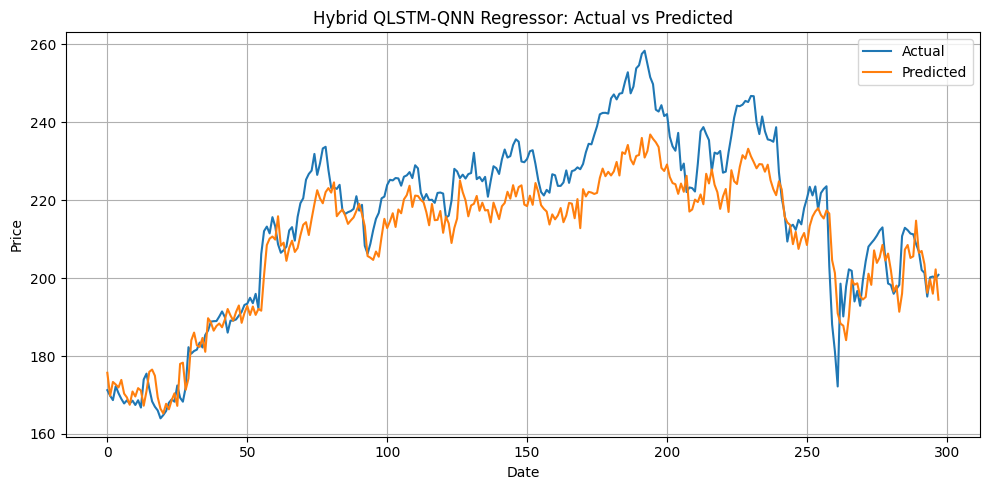

In [94]:
# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("Hybrid QLSTM-QNN Regressor: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
#os.makedirs("images", exist_ok=True)
#plt.savefig("images/qlstm_qnn_hybrid_plot.png", dpi=300)
plt.show()

## Plot Training and Validation Loss


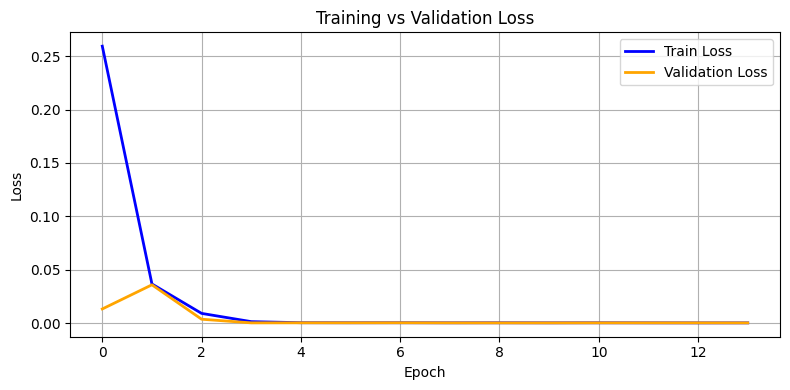

In [95]:
# === Plot Training & Validation Loss Curves ===
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", color="blue", linewidth=2)
plt.plot(val_losses, label="Validation Loss", color="orange", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("images/qlstm_qnn_loss_curve.png", dpi=300)
plt.show()
plt.close()

# Neural Network Architecture


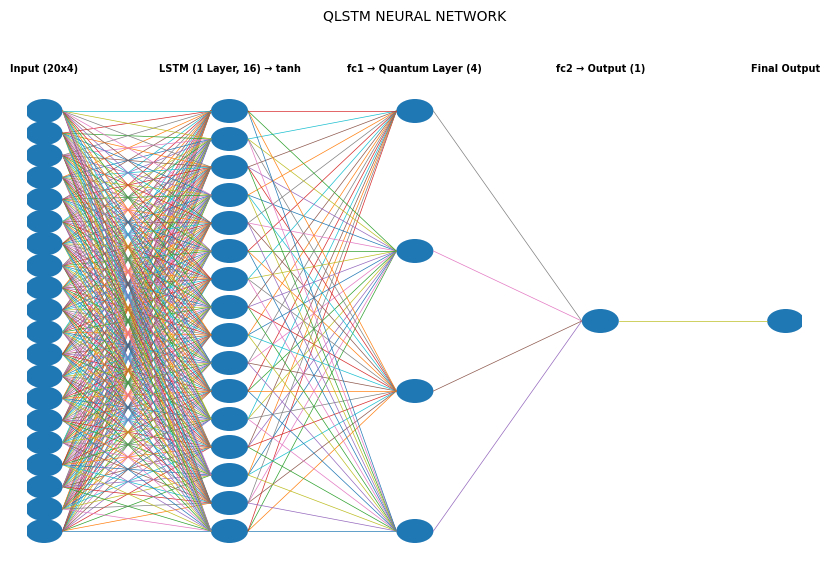

In [ ]:
def draw_network(layer_sizes, layer_labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    x_positions = np.linspace(0.1, 0.9, len(layer_sizes))
    for i, (n_nodes, x) in enumerate(zip(layer_sizes, x_positions)):
        y_positions = [0.5] if n_nodes == 1 else np.linspace(0.15, 0.85, n_nodes)
        for y in y_positions:
            circle = plt.Circle((x, y), 0.02, fill=True)
            ax.add_artist(circle)
        ax.text(x, 0.92, layer_labels[i], ha='center', va='center', fontsize=7, weight='bold')
        if i < len(layer_sizes) - 1:
            next_n = layer_sizes[i + 1]
            next_x = x_positions[i + 1]
            next_y_positions = [0.5] if next_n == 1 else np.linspace(0.15, 0.85, next_n)
            for y1 in y_positions:
                for y2 in next_y_positions:
                    ax.plot([x + 0.02, next_x - 0.02], [y1, y2], linewidth=0.5)
    ax.set_title("QLSTM NEURAL NETWORK", fontsize=10, pad=50)
    plt.show()
    plt.close()

# Draw neural network
layer_sizes = [seq_length, 16, num_qubits, 1, 1]
layer_labels = [
    f"Input ({seq_length}x4)",
    "LSTM (1 Layer, 16) → tanh",
    f"fc1 → Quantum Layer ({num_qubits})",
    "fc2 → Output (1)",
    "Final Output"
]
draw_network(layer_sizes, layer_labels)